# Imports

In [83]:
import ast
import numpy as np
import pandas as pd
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt

from tqdm import tqdm

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

seed = 42

np_qml.random.seed(seed)

In [6]:
import warnings

warnings.filterwarnings('ignore', message=".*Graph is not fully connected.*")

# VQC`s

## Circuit

In [29]:
dev = qml.device("lightning.gpu", wires=2)

def statepreparation(x):
    # qml.AmplitudeEmbedding(features=x, wires=range(2), pad_with=0)
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def apply_layer(W, layer_number):
    for i in range(len(W) // 2):
        qml.Rot(W[2 * i, 0], W[2 * i, 1], W[2 * i, 2], wires=0)
        qml.Rot(W[2 * i + 1, 0], W[2 * i + 1, 1], W[2 * i + 1, 2], wires=1)
        if i % 2 == 0:
            qml.CNOT(wires=[0, 1])
        else:
            qml.CNOT(wires=[1, 0]) if layer_number > 1 else qml.CNOT(wires=[0, 1])

def circuit(weights, X, layer_number):
    statepreparation(X)

    for W in weights:
        apply_layer(W, layer_number)

    return qml.expval(qml.PauliZ(wires=0))

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X):
    return circuit(weights, X, 1)

## Map Prediction

In [16]:
def map_prediction(pred):
    pred = np_qml.array(pred)
    pred = 2 / (1 + np_qml.exp(-pred)) - 1 # Coloca os valores para o intervalo de -1 a 1

    pred = np.array(list(map(lambda x: 1 if x >= 0 else -1, pred))) # Aplica o limitador para mapear os valores para 1 ou -1
    return pred

## Show Decision Region

In [17]:
def print_decision_region(X, qnode, x_max, y_max, weights, bias, predictions):
    plt.figure()
    cm = 'viridis'

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [qvc_classifier(qnode, weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 1])

    # if predictions are provided, plot data points colored by predictions
    predictions = np.array(predictions)
    
    # Pinta os pontos baseados nas previsões
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=predictions,  # Usa as previsões para determinar as cores
        cmap='viridis',  # Mapa de cores para representar os valores contínuos de previsões
        marker="o",
        edgecolors="k"
    )

    plt.show()


## Cost Function

### Davies Bouldin Index

In [60]:
def davies_bouldin_index(X, labels):
    """
    Compute the Davies-Bouldin Index for clustering.
    
    Parameters:
    X (numpy.ndarray): Dataset with shape (n_samples, n_features).
    labels (numpy.ndarray): Cluster labels for each sample with shape (n_samples,).
    
    Returns:
    float: Davies-Bouldin Index (lower values indicate better clustering).
    """
    n_clusters = len(np.unique(labels))
    if n_clusters <= 1:
        return 5
    
    # Compute cluster centers
    cluster_centers = np.array([X[labels == i].mean(axis=0) for i in [-1, 1]])
    
    # Compute intra-cluster distances (average distance to cluster center)
    intra_cluster_distances = np.zeros(n_clusters)
    for i in [-1, 1]:
        intra_cluster_distances[i] = np.mean(
            np.linalg.norm(X[labels == i] - cluster_centers[i], axis=1)
        )
    
    # Compute pairwise distances between cluster centers
    inter_cluster_distances = euclidean_distances(cluster_centers)
    
    # Compute Davies-Bouldin Index
    db_index = 0
    for i in [-1, 1]:
        max_ratio = 0
        for j in [-1, 1]:
            if i != j:
                if inter_cluster_distances[i, j] != 0:
                    ratio = (intra_cluster_distances[i] + intra_cluster_distances[j]) / inter_cluster_distances[i, j]
                    max_ratio = max(max_ratio, ratio)
        print(max_ratio)
        db_index += max_ratio
    
    db_index /= n_clusters

    return db_index


### Cost

In [79]:
def cost(
        weights,
        bias, 
        qnode,
        features
    ):
    predictions = np_qml.array(
        [
            qvc_classifier(
                qnode,
                weights, 
                bias, 
                xi
            ) for xi in features
        ]
    )

    predictions = map_prediction(predictions)    

    if len(np.unique(predictions)) == 1: # Penaliza o circuito se tiver prevendo somente um cluster
        metric = np_qml.float16(5)
    else: 
        # metric = davies_bouldin_score(features, predictions)
        metric = 1 - silhouette_score(features, predictions)
    # l2 = 0.01 * (np_qml.sum(bias**2) + np_qml.sum(weights**2))
    
    return metric

## Train Function

In [67]:
def train_kfold(
        qnode, 
        features, 
        num_params_w_lines, 
        num_params_w_columns, 
        num_layers, 
        weight_init_max, 
        optimizer, 
        dic_optimizer, 
        seed, 
        iterations=100, 
        k=10,
        log_interval=20,
        batch_size=32,
        show_log=False
    ):

    # Inicialização do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)

    folders_metrics = []
    
    # Loop pelos folds do k-fold
    for fold_idx, (train_index, val_index) in enumerate(kf.split(features)):
    # for fold_idx, (train_index, val_index) in tqdm(enumerate(kf.split(features)), desc="Treinando Folders", ncols=10):
        X_train, X_val = features[train_index], features[val_index]

        all_costs = []  # Para armazenar os valores da função de custo
        all_iterations = []

        # print(f"Treinando Fold {fold_idx + 1}/{k}")

        # Inicialização do otimizador
        opt = optimizer(**dic_optimizer)
        
        # Configuração padrão para os outros otimizadores
        weights_init = weight_init_max * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)

        bias_init = np_qml.array(0.0, requires_grad=True)

        weights = weights_init
        bias = bias_init

        folder_infos = {
            "folder": fold_idx + 1,
            "best_weights": weights,
            "best_bias": bias,
            "best_cost": float('inf'),
            "silhouette": float('inf'),
            "davies_bouldin": float('inf'),
            "calinski_harabasz": float('inf')
        }

        # Treinamento para o número de iterações desejado

        for it in range(0, iterations):
        # for it in tqdm(range(0, iterations), desc="Treinando Iterações", ncols=100):
            batch_size = len(X_train)
            # Mini-batch aleatório
            batch_index = np_qml.random.randint(0, len(X_train), batch_size)
            X_train_batch = X_train[batch_index]

            # Treinamento do modelo no batch
            arguments = [weights, bias]

            (weights, bias), iteration_cost = opt.step_and_cost(lambda w, b: cost(w, b, qnode, X_train_batch), *arguments)
            print('Weights: ', weights)
            print('Bias: ', bias)
            if iteration_cost < folder_infos['best_cost']:
                folder_infos['best_weights'] = weights
                folder_infos['best_bias'] = bias
                folder_infos['best_cost'] = iteration_cost
    
            all_costs.append(iteration_cost)
            all_iterations.append(it + 1)        

            # if it % 10 == 0:
            #     tqdm.write(f"Iter: {it:5} | Cost: {iteration_cost:10.7f} | Best Cost: {folder_infos['best_cost']:10.7f}")
            print(
                "Iter: {:5d} | Cost: {:0.7f} | Best Cost: {:0.7f}"
                .format(it + 1, iteration_cost, folder_infos['best_cost'])
            )

            if show_log and log_interval > 0 and (it % log_interval == 0 or it == iterations-1):
                predictions = [qvc_classifier(qnode, folder_infos['best_weights'], folder_infos['best_bias'], xi) for xi in X_train_batch]
                predictions = map_prediction(predictions)
                print_decision_region(X_train_batch, qnode, x_max=np.pi, y_max=np.pi, weights=folder_infos['best_weights'], bias=folder_infos['best_bias'], predictions=predictions)

        # Predição e cálculo da métrica de validação
        predictions_val = [qvc_classifier(qnode, folder_infos['best_weights'], folder_infos['best_bias'], xi) for xi in X_val]

        predictions_val = map_prediction(predictions_val)
        
        if not len(np.unique(predictions_val)) == 1:
            folder_infos['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
            folder_infos['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
            folder_infos['silhouette'] = silhouette_score(X_val, predictions_val)

        folders_metrics.append(folder_infos)

        if show_log:
            # Plotar o gráfico de custo apenas no final
            plt.plot(all_iterations, all_costs, label="Custo")
            plt.title("Evolução da Função de Custo (Final)")
            plt.xlabel("Iteração")
            plt.ylabel("Custo")
            plt.legend()
            plt.show()

    best_folder = min(folders_metrics, key=lambda d: d["best_cost"])

    print(f'A melhor Fold foi a {best_folder["folder"]}')
    print(f'Custo: {best_folder["best_cost"]}')
    print(f'Silhouette: {best_folder["silhouette"]}')
    print(f'Davies Bouldin: {best_folder["davies_bouldin"]}')
    print(f'Calinski Harabasz: {best_folder["calinski_harabasz"]}')

    predictions = [qvc_classifier(
        qnode, 
        best_folder['best_weights'], 
        best_folder['best_bias'], 
        xi
    ) for xi in features]

    predictions = map_prediction(predictions)

    print_decision_region(features, qnode, x_max=np.pi, y_max=np.pi, weights=best_folder['best_weights'], bias=best_folder['best_bias'], predictions=predictions)

    return best_folder["best_cost"], best_folder["best_weights"], best_folder["best_bias"], best_folder["silhouette"], best_folder["davies_bouldin"], best_folder["calinski_harabasz"]

## Execute Function

In [74]:
def execute(
        X, 
        result_archive_name,
        iterations=100,
        log_interval=20,
        batch_size=32,
        show_log=False
    ):
    # Definindo as combinações de otimizadores e circuitos a serem testados
    optimizers = {
        # 'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
        # 'GradientDescentOptimizer': GradientDescentOptimizer,
        'SPSAOptimizer': SPSAOptimizer
    }

    circuits = [
        (circuit_type1, 2), 
        # (circuit_type2, 4), 
        # (circuit_type3, 6), 
        # (circuit_type4, 6), 
        # (circuit_type5, 8)
    ]

    # Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
    optimizer_params = {
        'NesterovMomentumOptimizer': {'stepsize': 0.01, 'momentum': 0.7},
        'GradientDescentOptimizer': {'stepsize': 0.01},
        'SPSAOptimizer': {'maxiter': 100, 'alpha': 0.602, 'c': 0.101, 'gamma': 0.101}
    }

    # Parâmetros do experimento
    num_layers_options = [
        2, 
        # 4,
        # 6,
        # 8
    ]  # Escolher o número de camadas para o experimento

    # Armazenamento dos melhores resultados
    best_results = {
        'optimizer': None,
        'circuit_type': None,
        'num_layers': None,
        'score_davies': float('inf'),
        'score_calinski': float('inf'),
        'score_silhouette': float('inf'),
        'cost': float('inf'),
        'weights': None,
        'bias': None,
        'qnode': None
    }

    log_results = []
    best_cost = float('inf')

    # Loop para experimentar combinações
    for circuit_fn, num_params_w_lines in circuits:
        for optimizer_name, optimizer_class in optimizers.items():
            for num_layers in num_layers_options:
                print(f"{circuit_fn.__name__} - {optimizer_name} - {num_layers}")
                # Instanciar o circuito e o QNode
                circuit = circuit_fn
                qnode = qml.QNode(circuit, dev, interface="torch")

                # Treinamento com k-fold
                cost, weights, bias, score_silhouette, score_davies, score_calinski = train_kfold(
                    qnode,
                    X,
                    num_params_w_lines=num_params_w_lines,
                    num_params_w_columns=3,
                    num_layers=num_layers,
                    weight_init_max=np.pi,
                    optimizer=optimizer_class,
                    dic_optimizer=optimizer_params[optimizer_name],
                    seed=seed,
                    iterations=iterations,
                    k=10,
                    log_interval=log_interval,
                    batch_size=batch_size,
                    show_log=show_log
                )

                # Adicionar os resultados ao log
                log_results.append({
                    'circuit_fn': circuit_fn.__name__,
                    'optimizer': optimizer_name,
                    'num_layers': num_layers,
                    'score_davies': score_davies,
                    'score_calinski': score_calinski,
                    'score_silhouette': score_silhouette,
                    'cost': cost,
                    'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                    'bias': bias.tolist(),  # Convertendo para lista, caso seja um array
                })

                # Armazenar os melhores resultados
                if cost < best_cost:
                    best_results.update({
                        'optimizer': optimizer_name,
                        'circuit_type': circuit_fn.__name__,
                        'num_layers': num_layers,
                        'score_davies': score_davies,
                        'score_calinski': score_calinski,
                        'score_silhouette': score_silhouette,
                        'cost': cost,
                        'weights': weights,
                        'bias': bias,
                        'qnode': qnode
                    })

    # Exibir os melhores parâmetros e resultados
    print("Melhores Resultados:")
    print(f"Otimizer: {best_results['optimizer']}")
    print(f"Circuit Type: {best_results['circuit_type']}")
    print(f"Num Layers: {best_results['num_layers']}")
    print(f"Cost: {cost}")
    print(f"Avg Score Davies: {best_results['score_davies']}")
    print(f"Avg Score Calinski: {best_results['score_calinski']}")
    print(f"Avg Score Silhouette: {best_results['score_silhouette']}")

    # Salvar o log em uma planilha CSV
    log_df = pd.DataFrame(log_results)

    # Ou salvar em Excel (se preferir)
    log_df.to_excel(f'{result_archive_name}.xlsx', index=False)

    predictions = np_qml.array(
        [
            qvc_classifier(
                best_results['qnode'],
                best_results['weights'], 
                best_results['bias'], 
                xi
            ) for xi in X
        ]
    )

    predictions = map_prediction(predictions)

    # Visualizar a decisão do melhor modelo
    print_decision_region(
        X, 
        best_results['qnode'], 
        x_max=np.pi, 
        y_max=np.pi, 
        weights=best_results['weights'], 
        bias=best_results['bias'], 
        predictions=predictions
    )


# Datasets

## Utils

### Normalize

In [20]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

## 2 Circles 2 Class

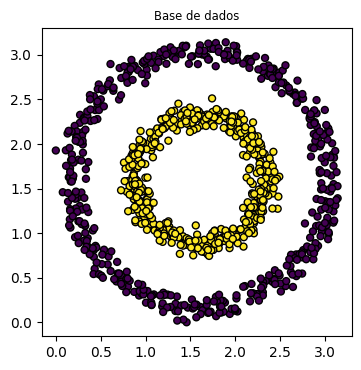

In [70]:
X, y = make_circles(
    (500, 500), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

### Execution

In [82]:
execute(X, "circle", iterations=10, log_interval=1, batch_size=64, show_log=False)

circuit_type1 - SPSAOptimizer - 2


LightningException: [/opt/pennylane-lightning/pennylane_lightning/core/src/utils/cuda_utils/DataBuffer.hpp][Line:142][Method:zeroInit]: Error in PennyLane Lightning: unknown error